# Import Libraries / Load Data

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
import xgboost as xg
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style =  "whitegrid")

In [2]:
PATH = "items.csv"
data = pd.read_csv(PATH)

# Data Analysis

In [3]:
data.shape

(86350, 97)

In [4]:
data.head()

,url,is_blog,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,length_url,email_in_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,length_domain,in_ip_domain,...,qty_percent_path,length_path,qty_dot_query,qty_hyphen_query,qty_underline_query,qty_slash_query,qty_questionmark_query,qty_equal_query,qty_at_query,qty_and_query,qty_exclamation_query,qty_space_query,qty_tilde_query,qty_comma_query,qty_plus_query,qty_asterisk_query,qty_hashtag_query,qty_dollar_query,qty_percent_query,length_query,qty_elements_query,tdl_present_query,qty_dot_fragment,qty_hyphen_fragment,qty_underline_fragment,qty_slash_fragment,qty_questionmark_fragment,qty_equal_fragment,qty_at_fragment,qty_and_fragment,qty_exclamation_fragment,qty_space_fragment,qty_tilde_fragment,qty_comma_fragment,qty_plus_fragment,qty_asterisk_fragment,qty_hashtag_fragment,qty_dollar_fragment,qty_percent_fragment,length_fragment
0,https://windowstoworlds.wordpress.com/index/,1,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://windowstoworlds.wordpress.com/features...,1,2,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://windowstoworlds.wordpress.com/2021/05/...,1,2,6,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,79,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://windowstoworlds.wordpress.com/2020/10/...,1,2,5,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,74,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,https://windowstoworlds.wordpress.com/2020/11/...,1,2,6,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,80,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Target Analysis

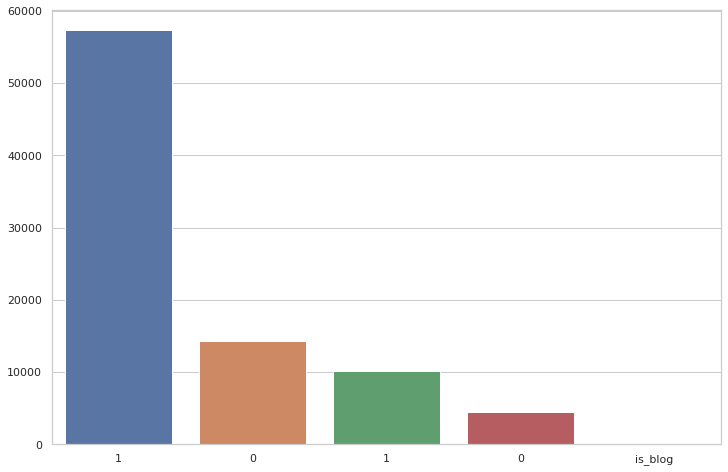

In [5]:
def plotTargetCounts(data,
                     target):
    ###
    ### Plots value counts of target feature as bar plot for better analysis
    ### @params = {data: dataset to examine, target: target feature for plotting}
    ###
    target = data[target].value_counts()
    plt.figure(figsize = (12,8))
    sns.barplot(x = target.keys(),
                y = target.values)
    plt.show()

plotTargetCounts(data, "is_blog")

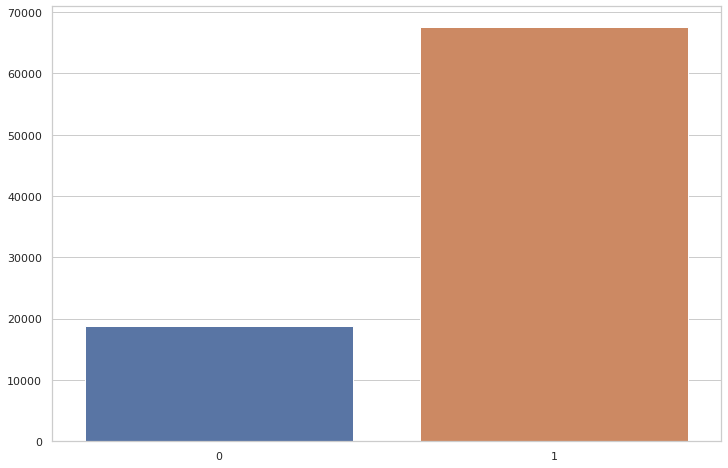

In [6]:
data = data[data["is_blog"] != "is_blog"]
data["is_blog"] = data["is_blog"].astype(int)
plotTargetCounts(data, "is_blog")

In [7]:
data["is_blog"].value_counts()

1    67562
0    18785
Name: is_blog, dtype: int64

In [8]:
data.drop(data[data["is_blog"] == 1].index.tolist()[-42000:],
         axis = 0,
         inplace = True)

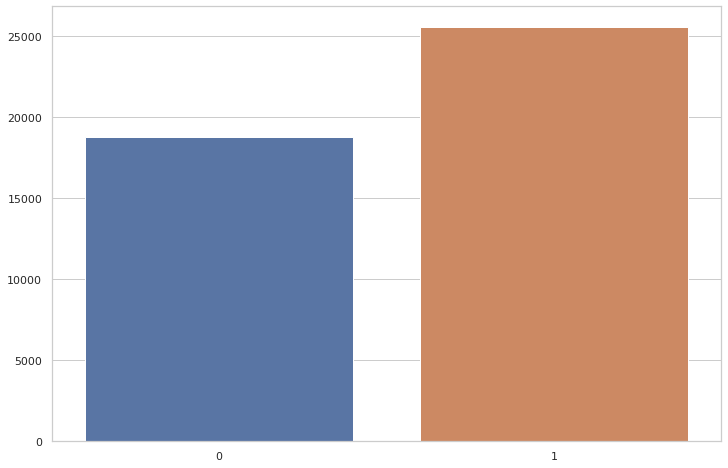

In [9]:
plotTargetCounts(data, "is_blog")

In [10]:
data["is_blog"].value_counts()

1    25562
0    18785
Name: is_blog, dtype: int64

## Missing Values

In [11]:
data.isna().sum()

url                      0
is_blog                  0
qty_dot_url              0
qty_hyphen_url           0
qty_underline_url        0
                        ..
qty_asterisk_fragment    0
qty_hashtag_fragment     0
qty_dollar_fragment      0
qty_percent_fragment     0
length_fragment          0
Length: 97, dtype: int64

In [12]:
pd.DataFrame(data.isna().sum() ,
             columns=["naCount"]).\
             reset_index().\
             rename(columns = {"index" : "columnName" }).\
             sort_values(by = "naCount")

,columnName,naCount
0,url,0
69,qty_tilde_query,0
68,qty_space_query,0
67,qty_exclamation_query,0
66,qty_and_query,0
...,...,...
27,qty_at_domain,0
26,qty_equal_domain,0
25,qty_questionmark_domain,0
47,qty_at_path,0


## Outlier Analysis

In [13]:
colsForOutlierAnalyze = [col for col in data.columns if len(data[col].value_counts().keys()) > 100]
colsForOutlierAnalyze

['url', 'length_url', 'length_path']

In [ ]:
def boxPlot(data, colsForOutlierAnalyze):
## 
## Boxplots for detect outlier values
## @params = {data: dataset for analyze, colsForOutlierAnalyze: Numeric columns in dataset}
##
    plt.subplots(nrows = 3,
              ncols = 1,
              figsize = (15,15))
    for i in range(len(colsForOutlierAnalyze)):
        plt.subplot(3,1,i+1)
        sns.boxplot(x = "is_blog", y = colsForOutlierAnalyze[i], data = data)
  #plt.title(colsForOutlierAnalyze[i])
#boxPlot(data, colsForOutlierAnalyze)

## Dtypes

In [15]:
data.dtypes

url                      object
is_blog                   int64
qty_dot_url              object
qty_hyphen_url           object
qty_underline_url        object
                          ...  
qty_asterisk_fragment    object
qty_hashtag_fragment     object
qty_dollar_fragment      object
qty_percent_fragment     object
length_fragment          object
Length: 97, dtype: object

In [16]:
for column in data.columns[1:]:
    data[column] = data[column].astype(int)

In [17]:
data = data.sample(frac=1).reset_index(drop=True) ## Need to shuffle dataset

# Train-Test Split

In [18]:
def trainTestSplitData(data, trainLen, valLen):
##
## Splits data for train (Model Training) and test (Model Evaluating)
## @params = {data: data for split, testLen: train data ratio}
## @returns = {x_train, x_test, y_train, y_test, x_val, y_val : base and target data for model}
##
    X = data.drop(["is_blog", "url"], 
                  axis = 1)
    y = data["is_blog"]
    urls = data["url"]
    trainLen = int(data.shape[0] * trainLen)
    valLen = trainLen - int(trainLen * valLen)  
    x_train, x_test, y_train, y_test, test_urls = X[:trainLen], X[trainLen:], y[:trainLen], y[trainLen:], urls[trainLen:]
    x_train, x_val, y_train, y_val = x_train[:valLen], x_train[valLen:], y_train[:valLen], y_train[valLen:]
    del X
    del y
    return x_train, x_test, x_val, y_train, y_test, y_val, test_urls

In [19]:
x_train, x_test, x_val, y_train, y_test, y_val, test_urls = trainTestSplitData(data, 0.8, 0.15)

In [20]:
print(f"Train Data Shape: {x_train.shape} Train Target Shape: {y_train.shape}")
print(f"Validation Data Shape: {x_val.shape} Validation Target Shape: {y_val.shape}")
print(f"Test Data Shape: {x_test.shape} Test Target Shape: {y_test.shape}")

Train Data Shape: (30156, 95) Train Target Shape: (30156,)
Validation Data Shape: (5321, 95) Validation Target Shape: (5321,)
Test Data Shape: (8870, 95) Test Target Shape: (8870,)


# Model Selection

In [21]:
def gridSearchCrossValidation(tunedParams,
                              scores,
                              x_train,
                              x_val,
                              y_train,
                              y_val,
                              modelType = "KNN"
                              ):
    ###
    ### Cross Validation for test model metric and hyper-parameter tuning
    ### @params = {tunedParams: hyper-parameters for dataset, scores: accuracy metrics, x_train/y_train/x_val/y_val: datasets, modelType: algorithm type (KNN, RF, XGB)}
    ###
    for score in scores:
        print(f"Hyper-Parameter Tuning for {score}")
        if modelType == "KNN":
            model = GridSearchCV(KNeighborsClassifier(),
                       tunedParams,
                       scoring = f"{score}_macro")
        elif modelType == "RF":
            model = GridSearchCV((RandomForestClassifier()),
                       tunedParams,
                       scoring = f"{score}_macro")
        elif modelType == "XGB":
            model = GridSearchCV(xg.XGBClassifier(),
                       tunedParams,
                       scoring = f"{score}_macro")
        
        model.fit(x_train, y_train)
        print("Best parameters set found on development set:")
        print(model.best_params_)
        print("Grid scores on development set:")
        means = model.cv_results_['mean_test_score']
        stds = model.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print("Detailed classification report:")
        y_true, y_pred = y_val, model.predict(x_val)
        print(classification_report(y_true, y_pred))

In [22]:
tunedParams = [{"n_neighbors": [3,5,7],
                "weights": ["uniform", "distance"],
                "p": [1,2]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "KNN")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Grid scores on development set:
0.994 (+/-0.002) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.995 (+/-0.001) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.994 (+/-0.002) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.995 (+/-0.001) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.991 (+/-0.004) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.995 (+/-0.002) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.991 (+/-0.003) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.994 (+/-0.002) for {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.990 (+/-0.003) for {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.994 (+/-0.002) for {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.990 (+/-0.003) for {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.994 (+/-0.002) for {'n_neighbors': 7, 'p': 2, 'weights': '

In [23]:
tunedParams = [{"n_estimators": [10, 50, 100],
                "criterion": ["gini", "entropy"],
                "max_features": ["auto", "sqrt", "log2"]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "RF")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
Grid scores on development set:
0.998 (+/-0.002) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 50}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}
0.999 (+/-0.001) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.998 (+/-0.001) for {'criterion

In [24]:
tunedParams = [{"min_child_weight": [5, 10],
                "colsample_bytree": [0.6, 0.8]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_val,
                          y_train,
                          y_val,
                          modelType = "XGB")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'colsample_bytree': 0.6, 'min_child_weight': 5}
Grid scores on development set:
0.999 (+/-0.001) for {'colsample_bytree': 0.6, 'min_child_weight': 5}
0.998 (+/-0.001) for {'colsample_bytree': 0.6, 'min_child_weight': 10}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'min_child_weight': 5}
0.998 (+/-0.001) for {'colsample_bytree': 0.8, 'min_child_weight': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       1.00      1.00      1.00      2988

    accuracy                           1.00      5321
   macro avg       1.00      1.00      1.00      5321
weighted avg       1.00      1.00      1.00      5321

Hyper-Parameter Tuning for recall
Best parameters set found on development set:
{'colsample_bytree': 0.8, 'min_child_weight': 5}
Grid scores on development set:
0.998 (+/-0.001) for {'colsample_b

# Model Evaluation

In [25]:
model = xg.XGBClassifier(colsample_bytree =  0.6, 
                         min_child_weight = 5)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<Figure size 1440x1440 with 0 Axes>

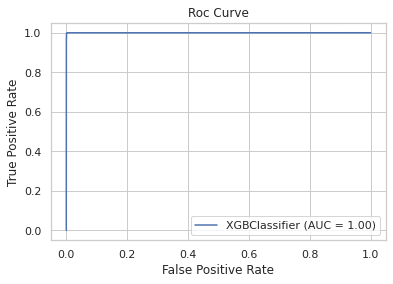

In [26]:
plt.figure(figsize= (20,20))
plot_roc_curve(model, x_test, y_test)
plt.title("Roc Curve")
plt.show()

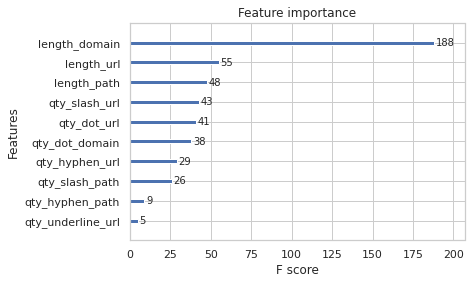

In [27]:
plot_importance(model, max_num_features=10) # top 10 most important features
plt.show()

In [28]:
predicts = model.predict(x_test)
predictionData = {"Index": test_urls,
                      "Actual": y_test,
                      "Prediction": predicts}
predictionData = pd.DataFrame(predictionData)
predictionData

,Index,Actual,Prediction
35477,https://www.oyunskor.com/oyun/miranda-manicure,0,0
35478,http://addictedtoromance.org/books/cupids-ench...,1,1
35479,https://kitchentoast.com/wheatgrass-juicer-man...,1,1
35480,https://www.oyunskor.com/oyun/bubble-witch,0,0
35481,https://thegeekybibliophile.wordpress.com/2016...,1,1
...,...,...,...
44342,https://www.gleefulblogger.com/how-to-develop-...,1,1
44343,http://addictedtoromance.org/tag/sherring-cross/,1,1
44344,https://www.oyunskor.com/oyun/papa-louie,0,0
44345,https://www.oyunskor.com/oyun/valentines-shop,0,0


In [29]:
def getClassAccuracies(predictionData):
    ###
    ### Gets accuracies of model for all unique classes
    ### @params = {predictionaData: Preproccessed data cols = ["Index", "Actual", "Prediction"]}
    ###
    positives = predictionData[predictionData["Actual"] == 1]
    posRatio = ((positives["Actual"] == positives["Prediction"]).sum() / positives.shape[0]) * 100
    negatives = predictionData[predictionData["Actual"] == 0]
    negRatio = ((negatives["Actual"] == negatives["Prediction"]).sum() / negatives.shape[0]) * 100
    print(f"Model Accuracy for predict blogs: {posRatio}\nModel Accuracy for predict non-blogs: {negRatio}")
getClassAccuracies(predictionData)

Model Accuracy for predict blogs: 100.0
Model Accuracy for predict non-blogs: 99.5545073375262
